# NHIS

**Notable assumptions being made**
* Sample data from has similar distribution as general US population (e.g. income class, region)

In [12]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import statsmodels.api as sm
import seaborn as sns


import os
        
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

In [2]:
pd.set_option('display.max_rows', 500)  # Set the option to display all rows
pd.set_option('display.max_columns', 100)  # Set the option to display all rows


In [59]:
#import data and reserve the originals as read only

dfc22_orig = pd.read_csv('source/child22.csv')
dfa22_orig = pd.read_csv('source/adult22.csv')
dfc21_orig = pd.read_csv('source/child21.csv')
dfa21_orig = pd.read_csv('source/adult21.csv')
dfc20_orig = pd.read_csv('source/child20.csv')
dfa20_orig = pd.read_csv('source/adult20.csv')
dfc19_orig = pd.read_csv('source/child19.csv')
dfa19_orig = pd.read_csv('source/adult19.csv')



#Copying to working dataframe, also removing columns not planned to be used
dfc22 = dfc22_orig[["RECTYPE","SRVY_YR","HHX","REGION","INTV_MON","HHSTAT_C","RELTIVP_C","SEX_C","AGEP_C","PCNTLT18TC","PCNT18UPTC","PCNTADLT_C","PCNTKIDS_C","MLTFAMFLG_C","PHSTAT_C","LSATIS11_C","ASEV_C","ASTILL_C","PREDIB_C","DIBEV_C","ADHDEV_C","ADHDNW_C","IDEV1_C","IDNW1_C","ASDEV_C","ASDNW_C","DDEV_C","DDNW_C","LDEV_C","LDNW_C","PICKUPDF_C","SELFCAREDF_C","UNDRSTYOU_C","UNDRSTCHD_C","UNDRSTIHH_C","UNDRSTOHH_C","LEARNDF_C","REMEMBERDF_C","ANXFREQ_C","DEPFREQ_C","BEHDFPLYG_C","BEHDFCNTR_C","BEHDFFCS_C","BEHDFCHG_C","BEHDFMKFR_C","BSCNWPPL_C","BSCNWPLCS_C","BSCCHG_C","BSCHLOPPL_C","BSCCRYALT_C","BSCCLMDWN_C","BSCFUSSY_C","BSCSTHE_C","BSCSCHD_C","BSCPTSLP_C","BSCSTYSLP_C","BSCPRLKSL_C","SCHSPEDEV_C","SCHSPED_C","SCHSPEDEM_C","MHRX_C","MHTHRPY_C","SUPPORT_C","COMSUPPORT_C","SDQ1_C","SDQ2_C","SDQ3_C","SDQ4_C","SDQ5_C","SDQ6_C","SDQ7_C","SDQ8_C","SDQ9_C","SDQ10_C","SDQ11_C","SDQ12_C","SDQ13_C","SDQ14_C","SDQ15_C","SDQ16_C","SDQ17_C","SDQ18_C","SDQ19_C","SDQ20_C","SDQ21_C","SDQ22_C","SDQ23_C","SDQ24_C","SDQ25_C","SDQIMP1_C","SDQIMP2_C","SDQIMP3_C","SDQIMP4_C","SDQIMP5_C","SDQIMP6_C","SDQIMP7_C","SDQIMP8_C","SDQEMOT_C","SDQCOND_C","SDQHYPE_C","SDQPEER_C","SDQPROS_C","SDQTOT_C","SDQIMPTOT_C","VIOLENEV_C","JAILEV1_C","MENTDEPEV_C","ALCDRUGEV_C","PUTDOWN_C","BNEEDS_C","UNFAIRRE_C","UNFAIRSO_C","BULLYVIC_C","CYBERVIC_C","BULLYPERP_C","POVRATTC_C","RATCAT_C"]].copy()
dfc21 = dfc21_orig[["RECTYPE","SRVY_YR","HHX","REGION","INTV_MON","HHSTAT_C","RELTIVP_C","SEX_C","AGEP_C","PCNTLT18TC","PCNT18UPTC","PCNTADLT_C","PCNTKIDS_C","MLTFAMFLG_C","PHSTAT_C","LSATIS11_C","ASEV_C","ASTILL_C","PREDIB_C","DIBEV_C","ADHDEV_C","ADHDNW_C","ASDEV_C","ASDNW_C","DDEV_C","DDNW_C","LDEV_C","LDNW_C","PICKUPDF_C","SELFCAREDF_C","UNDRSTYOU_C","UNDRSTCHD_C","UNDRSTIHH_C","UNDRSTOHH_C","LEARNDF_C","REMEMBERDF_C","ANXFREQ_C","DEPFREQ_C","BEHDFPLYG_C","BEHDFCNTR_C","BEHDFFCS_C","BEHDFCHG_C","BEHDFMKFR_C","BSCNWPPL_C","BSCNWPLCS_C","BSCCHG_C","BSCHLOPPL_C","BSCCRYALT_C","BSCCLMDWN_C","BSCFUSSY_C","BSCSTHE_C","BSCSCHD_C","BSCPTSLP_C","BSCSTYSLP_C","BSCPRLKSL_C","SCHSPEDEV_C","SCHSPED_C","SCHSPEDEM_C","MHRX_C","MHTHRPY_C","SUPPORT_C","COMSUPPORT_C","VIOLENEV_C","JAILEV1_C","MENTDEPEV_C","ALCDRUGEV_C","PUTDOWN_C","BNEEDS_C","UNFAIRRE_C","UNFAIRSO_C","BULLYVIC_C","CYBERVIC_C","BULLYPERP_C","POVRATTC_C","RATCAT_C"]].copy()
dfc20 = dfc20_orig[["RECTYPE","SRVY_YR","HHX","REGION","INTV_MON","HHSTAT_C","RELTIVP_C","SEX_C","AGEP_C","PCNTLT18TC","PCNT18UPTC","PCNTADLT_C","PCNTKIDS_C","MLTFAMFLG_C","PHSTAT_C","ASEV_C","ASTILL_C","PREDIB_C","DIBEV_C","ADHDEV_C","ADHDNW_C","ASDEV_C","ASDNW_C","DDEV_C","DDNW_C","LDEV_C","LDNW_C","PICKUPDF_C","SELFCAREDF_C","UNDRSTYOU_C","UNDRSTCHD_C","UNDRSTIHH_C","UNDRSTOHH_C","LEARNDF_C","REMEMBERDF_C","ANXFREQ_C","DEPFREQ_C","BEHDFPLYG_C","BEHDFCNTR_C","BEHDFFCS_C","BEHDFCHG_C","BEHDFMKFR_C","BSCNWPPL_C","BSCNWPLCS_C","BSCCHG_C","BSCHLOPPL_C","BSCCRYALT_C","BSCCLMDWN_C","BSCFUSSY_C","BSCSTHE_C","BSCSCHD_C","BSCPTSLP_C","BSCSTYSLP_C","BSCPRLKSL_C","SCHSPEDEV_C","SCHSPED_C","SCHSPEDEM_C","MHRX_C","MHTHRPY_C","SUPPORT_C","COMSUPPORT_C","VIOLENEV_C","JAILEV1_C","MENTDEPEV_C","ALCDRUGEV_C","PUTDOWN_C","BNEEDS_C","UNFAIRRE_C","UNFAIRSO_C","BULLYVIC_C","CYBERVIC_C","BULLYPERP_C","POVRATTC_C","RATCAT_C"]].copy()
dfc19 = dfc19_orig[["RECTYPE","SRVY_YR","HHX","REGION","HHSTAT_C","RELTIVP_C","SEX_C","AGEP_C","PCNTLT18TC","PCNT18UPTC","PCNTADLT_C","PCNTKIDS_C","MLTFAMFLG_C","ADHDEV_C","ADHDNW_C","ASDEV_C","ASDNW_C","DDEV_C","DDNW_C","LDEV_C","LDNW_C","PICKUPDF_C","SELFCAREDF_C","UNDRSTYOU_C","UNDRSTCHD_C","UNDRSTIHH_C","UNDRSTOHH_C","LEARNDF_C","REMEMBERDF_C","ANXFREQ_C","DEPFREQ_C","BEHDFPLYG_C","BEHDFCNTR_C","BEHDFFCS_C","BEHDFCHG_C","BEHDFMKFR_C","BSCNWPPL_C","BSCNWPLCS_C","BSCCHG_C","BSCHLOPPL_C","BSCCRYALT_C","BSCCLMDWN_C","BSCFUSSY_C","BSCSTHE_C","BSCSCHD_C","BSCPTSLP_C","BSCSTYSLP_C","BSCPRLKSL_C","SCHSPEDEV_C","SCHSPED_C","SCHSPEDEM_C","MHRX_C","MHTHRPY_C","SDQ1_C","SDQ2_C","SDQ3_C","SDQ4_C","SDQ5_C","SDQ6_C","SDQ7_C","SDQ8_C","SDQ9_C","SDQ10_C","SDQ11_C","SDQ12_C","SDQ13_C","SDQ14_C","SDQ15_C","SDQ16_C","SDQ17_C","SDQ18_C","SDQ19_C","SDQ20_C","SDQ21_C","SDQ22_C","SDQ23_C","SDQ24_C","SDQ25_C","SDQIMP1_C","SDQIMP2_C","SDQIMP3_C","SDQIMP4_C","SDQIMP5_C","SDQIMP6_C","SDQIMP7_C","SDQIMP8_C","SDQEMOT_C","SDQCOND_C","SDQHYPE_C","SDQPEER_C","SDQPROS_C","SDQTOT_C","SDQIMPTOT_C","POVRATTC_C","RATCAT_C"]].copy()


#dfcall = pd.concat([dfc22,dfc21,dfc20,dfc19],axis=0)
dfcall = pd.concat([dfc22,dfc19],axis=0)

dfa22 = dfa22_orig.copy()


KeyError: "['LSATIS11_C', 'SUPPORT_C', 'COMSUPPORT_C', 'VIOLENEV_C', 'JAILEV1_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'PUTDOWN_C', 'BNEEDS_C', 'UNFAIRRE_C', 'UNFAIRSO_C', 'BULLYVIC_C', 'CYBERVIC_C', 'BULLYPERP_C'] not in index"

In [4]:
dfcall


,RECTYPE,SRVY_YR,HHX,REGION,INTV_MON,HHSTAT_C,RELTIVP_C,SEX_C,AGEP_C,PCNTLT18TC,PCNT18UPTC,PCNTADLT_C,PCNTKIDS_C,MLTFAMFLG_C,ADHDEV_C,ADHDNW_C,IDEV1_C,IDNW1_C,ASDEV_C,ASDNW_C,DDEV_C,DDNW_C,LDEV_C,LDNW_C,PICKUPDF_C,SELFCAREDF_C,UNDRSTYOU_C,UNDRSTCHD_C,UNDRSTIHH_C,UNDRSTOHH_C,LEARNDF_C,REMEMBERDF_C,ANXFREQ_C,DEPFREQ_C,BEHDFPLYG_C,BEHDFCNTR_C,BEHDFFCS_C,BEHDFCHG_C,BEHDFMKFR_C,BSCNWPPL_C,BSCNWPLCS_C,BSCCHG_C,BSCHLOPPL_C,BSCCRYALT_C,BSCCLMDWN_C,BSCFUSSY_C,BSCSTHE_C,BSCSCHD_C,BSCPTSLP_C,BSCSTYSLP_C,BSCPRLKSL_C,SCHSPEDEV_C,SCHSPED_C,SCHSPEDEM_C,MHRX_C,MHTHRPY_C,SUPPORT_C,COMSUPPORT_C,SDQ1_C,SDQ2_C,SDQ3_C,SDQ4_C,SDQ5_C,SDQ6_C,SDQ7_C,SDQ8_C,SDQ9_C,SDQ10_C,SDQ11_C,SDQ12_C,SDQ13_C,SDQ14_C,SDQ15_C,SDQ16_C,SDQ17_C,SDQ18_C,SDQ19_C,SDQ20_C,SDQ21_C,SDQ22_C,SDQ23_C,SDQ24_C,SDQ25_C,SDQIMP1_C,SDQIMP2_C,SDQIMP3_C,SDQIMP4_C,SDQIMP5_C,SDQIMP6_C,SDQIMP7_C,SDQIMP8_C,SDQEMOT_C,SDQCOND_C,SDQHYPE_C,SDQPEER_C,SDQPROS_C,SDQTOT_C,SDQIMPTOT_C,POVRATTC_C,RATCAT_C
0,20,2022,H053192,3,1.0,1,1,1,8,3,2,2,3,2,2.0,NaN,2.0,NaN,2.0,NaN,2,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,3.0,5.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2.0,2.0,NaN,NaN,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,10.0,2.0,NaN,11.00,14
1,20,2022,H040577,3,1.0,1,1,2,8,3,3,3,3,2,2.0,NaN,2.0,NaN,2.0,NaN,2,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,5.0,5.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2.0,2.0,NaN,NaN,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,1.0,2.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,1.0,10.0,3.0,NaN,1.07,4
2,20,2022,H033338,3,1.0,1,1,1,2,1,2,2,1,2,2.0,NaN,2.0,NaN,2.0,NaN,2,NaN,2.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,11
3,20,2022,H028319,3,1.0,1,1,2,14,1,1,1,1,2,1.0,1.0,2.0,NaN,2.0,NaN,2,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,3.0,NaN,1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,1.0,1.0,2.0,1.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,2.0,3.0,2.0,3.0,1.0,1.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,4.0,1.0,2.0,5.0,0.0,7.0,3.0,10.0,15.0,2.0,4.55,13
4,20,2022,H001424,3,1.0,1,1,1,7,3,1,1,3,2,2.0,NaN,2.0,NaN,2.0,NaN,2,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,5.0,5.0,NaN,4.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2.0,2.0,NaN,NaN,3.0,2.0,1.0,3.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,5.0,2.0,9.0,8.0,0.0,0.56,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9188,20,2019,H049550,2,NaN,1,1,1,13,1,2,2,1,2,2.0,NaN,NaN,NaN,2.0,NaN,2,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,4.0,5.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,NaN,2.0,2.0,NaN,NaN,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,10.0,1.0,NaN,4.20,12
9189,20,2019,H048857,4,NaN,1,1,1,13,1,2,2,1,2,2.0,NaN,NaN,NaN,2.0,NaN,2,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,4.0,4.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2.0,2.0,NaN,NaN,3.0,1.0,2.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [5]:
#Also importing the column description table so it's easier to refer to
cookbook_child = pd.read_csv('source/child-summary.csv')

In [6]:
#Checking shape
print(f"Child shape: {dfc22.shape} \nAdult shape: {dfa22.shape}")

Child shape: (7464, 100) 
Adult shape: (27651, 637)


# Analysis

## Missing/null values

In [7]:
#Checking null values & percentages

num_of_rows = dfc22.shape[0]

dfc_nullcheck = pd.DataFrame(dfc22.isna().sum().reset_index())
dfc_nullcheck = dfc_nullcheck.rename({0:'nulls'},axis=1)
dfc_nullcheck['percentage'] = dfc_nullcheck['nulls'] / num_of_rows
dfc_nullcheck['description'] = pd.merge(dfc_nullcheck, cookbook_child, left_on='index', right_on='Variable Name')['Description']
dfc_nullcheck.sort_values('percentage',ascending=False)

,index,nulls,percentage,description
17,IDNW1_C,7346,0.984191,Currently has intellectual disability
19,ASDNW_C,7220,0.967310,Currently has autism
21,DDNW_C,7091,0.950027,Currently has developmental delay
23,LDNW_C,6953,0.931538,Currently has learning disability
15,ADHDNW_C,6781,0.908494,Currently has ADD/ADHD
53,SCHSPEDEM_C,6742,0.903269,Currently receives services for mental health
42,BSCHLOPPL_C,6633,0.888666,Held by other people
39,BSCNWPPL_C,6633,0.888666,Hard time with new people
40,BSCNWPLCS_C,6633,0.888666,Hard time in new places
50,BSCPRLKSL_C,6633,0.888666,Hard to get sleep due to SC


### Observations/Notes

* Questions such as having ADHD or Autisma have very high % of data missing (vetted with NHIS' original document). After quick analysis, determined the "Currently has autism" question will be skipped if the user answered No to "Ever had autism" question. Therefore we can assume null = No for "Currently has autism question"
* SDQ questions only happen every 3 years, so with the new design we only have 2019 and 2022


## BSC* fields

In [8]:
#Comparing data when the BSC fields are blank VS not blank. 
pd.concat([dfc22[~dfc22['BSCHLOPPL_C'].isna()].head(10),dfc22[dfc22['BSCHLOPPL_C'].isna()].head(10)],axis=0)




,RECTYPE,SRVY_YR,HHX,REGION,INTV_MON,HHSTAT_C,RELTIVP_C,SEX_C,AGEP_C,PCNTLT18TC,PCNT18UPTC,PCNTADLT_C,PCNTKIDS_C,MLTFAMFLG_C,ADHDEV_C,ADHDNW_C,IDEV1_C,IDNW1_C,ASDEV_C,ASDNW_C,DDEV_C,DDNW_C,LDEV_C,LDNW_C,PICKUPDF_C,SELFCAREDF_C,UNDRSTYOU_C,UNDRSTCHD_C,UNDRSTIHH_C,UNDRSTOHH_C,LEARNDF_C,REMEMBERDF_C,ANXFREQ_C,DEPFREQ_C,BEHDFPLYG_C,BEHDFCNTR_C,BEHDFFCS_C,BEHDFCHG_C,BEHDFMKFR_C,BSCNWPPL_C,BSCNWPLCS_C,BSCCHG_C,BSCHLOPPL_C,BSCCRYALT_C,BSCCLMDWN_C,BSCFUSSY_C,BSCSTHE_C,BSCSCHD_C,BSCPTSLP_C,BSCSTYSLP_C,BSCPRLKSL_C,SCHSPEDEV_C,SCHSPED_C,SCHSPEDEM_C,MHRX_C,MHTHRPY_C,SUPPORT_C,COMSUPPORT_C,SDQ1_C,SDQ2_C,SDQ3_C,SDQ4_C,SDQ5_C,SDQ6_C,SDQ7_C,SDQ8_C,SDQ9_C,SDQ10_C,SDQ11_C,SDQ12_C,SDQ13_C,SDQ14_C,SDQ15_C,SDQ16_C,SDQ17_C,SDQ18_C,SDQ19_C,SDQ20_C,SDQ21_C,SDQ22_C,SDQ23_C,SDQ24_C,SDQ25_C,SDQIMP1_C,SDQIMP2_C,SDQIMP3_C,SDQIMP4_C,SDQIMP5_C,SDQIMP6_C,SDQIMP7_C,SDQIMP8_C,SDQEMOT_C,SDQCOND_C,SDQHYPE_C,SDQPEER_C,SDQPROS_C,SDQTOT_C,SDQIMPTOT_C,POVRATTC_C,RATCAT_C
7,20,2022,H019456,4,1,1,2,2,1,2,3,3,2,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,3.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.62,11
8,20,2022,H006250,4,1,1,1,2,1,2,2,2,2,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.63,11
33,20,2022,H015664,4,1,1,1,2,1,2,1,1,2,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,2
36,20,2022,H025236,4,1,1,1,2,0,1,2,2,1,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.00,14
46,20,2022,H046500,4,1,1,1,2,1,1,2,2,1,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.66,11
47,20,2022,H038806,4,1,1,1,1,0,1,2,2,1,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.96,14
50,20,2022,H002157,4,1,1,1,1,0,2,3,2,2,1,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.91,13
52,20,2022,H028273,4,1,1,1,1,0,1,3,3,1,2,NaN,NaN,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.99,9
56,20,2022,H040247,4,1,1,

### Observations
* Records that have BSC fields filled in are children that's 1 or younger (possibly 2). 

In [9]:
# Checking the NA value differences per age

dfc22.groupby('AGEP_C').apply(lambda x: x.isnull().sum())

,RECTYPE,SRVY_YR,HHX,REGION,INTV_MON,HHSTAT_C,RELTIVP_C,SEX_C,AGEP_C,PCNTLT18TC,PCNT18UPTC,PCNTADLT_C,PCNTKIDS_C,MLTFAMFLG_C,ADHDEV_C,ADHDNW_C,IDEV1_C,IDNW1_C,ASDEV_C,ASDNW_C,DDEV_C,DDNW_C,LDEV_C,LDNW_C,PICKUPDF_C,SELFCAREDF_C,UNDRSTYOU_C,UNDRSTCHD_C,UNDRSTIHH_C,UNDRSTOHH_C,LEARNDF_C,REMEMBERDF_C,ANXFREQ_C,DEPFREQ_C,BEHDFPLYG_C,BEHDFCNTR_C,BEHDFFCS_C,BEHDFCHG_C,BEHDFMKFR_C,BSCNWPPL_C,BSCNWPLCS_C,BSCCHG_C,BSCHLOPPL_C,BSCCRYALT_C,BSCCLMDWN_C,BSCFUSSY_C,BSCSTHE_C,BSCSCHD_C,BSCPTSLP_C,BSCSTYSLP_C,BSCPRLKSL_C,SCHSPEDEV_C,SCHSPED_C,SCHSPEDEM_C,MHRX_C,MHTHRPY_C,SUPPORT_C,COMSUPPORT_C,SDQ1_C,SDQ2_C,SDQ3_C,SDQ4_C,SDQ5_C,SDQ6_C,SDQ7_C,SDQ8_C,SDQ9_C,SDQ10_C,SDQ11_C,SDQ12_C,SDQ13_C,SDQ14_C,SDQ15_C,SDQ16_C,SDQ17_C,SDQ18_C,SDQ19_C,SDQ20_C,SDQ21_C,SDQ22_C,SDQ23_C,SDQ24_C,SDQ25_C,SDQIMP1_C,SDQIMP2_C,SDQIMP3_C,SDQIMP4_C,SDQIMP5_C,SDQIMP6_C,SDQIMP7_C,SDQIMP8_C,SDQEMOT_C,SDQCOND_C,SDQHYPE_C,SDQPEER_C,SDQPROS_C,SDQTOT_C,SDQIMPTOT_C,POVRATTC_C,RATCAT_C
AGEP_C,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,417,417,0,417,417,417,0,413,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,0,0,0,0,0,0,0,0,0,0,0,0,0,410,412,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,414,414,0,413,414,414,0,399,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,0,0,0,0,0,0,0,0,0,0,0,0,0,402,409,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,414,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,362,0,358,0,351,0,339,0,355,0,362,0,0,362,362,0,362,362,362,0,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,0,334,342,0,0,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,362,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,385,0,386,0,381,0,362,0,380,0,389,0,0,389,389,0,389,389,389,0,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,0,358,366,0,0,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,389,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,378,0,375,0,371,0,355,0,372,0,384,0,0,384,384,0,384,384,384,0,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,384,0,347,354,0,0,384,384,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,277,277,277,277,277,277,277,0,0,0,0,0,0,277,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,415,0,421,0,404,0,398,0,412,425,0,425,425,0,0,0,0,0,0,425,0,0,0,0,425,425,425,425,425,425,425,425,425,425,425,425,0,383,395,0,0,425,425,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,307,307,307,307,307,307,307,0,0,0,0,0,0,307,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,368,0,392,0,388,0,382,0,379,397,0,397,397,0,0,0,0,0,0,397,0,0,0,0,397,397,397,397,397,397,397,397,397,397,397,397,0,345,359,0,0,397,397,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,263,263,263,263,263,263,263,0,0,0,0,0,0,263,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,354,0,378,0,366,0,349,0,353,380,0,380,380,0,0,0,0,0,0,380,0,0,0,0,380,380,380,380,380,380,380,380,380,380,380,380,0,321,341,0,0,380,380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,264,264,264,264,264,264,264,0,0,0,0,0,0,264,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,306,0,349,0,342,0,337,0,321,353,0,353,353,0,0,0,0,0,0,353,0,0,0,0,353,353,353,353,353,353,353,353,353,353,353,353,0,295,308,0,0,353,353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,236,236,236,236,236,236,0,0,0,0,0,0,236,0,0


As suspected, different questions are answered based on age. 
There seems to be different set of questions from: 
* 0-1
* 2-4
* 5-17 (SUPPORT_C and COMSUPPORT_C is not answered above 12, presumably by some age limits)

## [Working analysis]

In [32]:
dfcall_yearly = pd.DataFrame(dfcall['SRVY_YR'].sort_values().unique(),columns=['year'])
dfcall_yearly['all_count'] = pd.DataFrame(dfcall.groupby('SRVY_YR')['ADHDEV_C'].count().reset_index())['ADHDEV_C']
dfcall_yearly['adhd_count'] = pd.DataFrame(dfcall.loc[dfcall['ADHDEV_C']==1.0,['SRVY_YR','ADHDEV_C']].groupby('SRVY_YR')['ADHDEV_C'].count().reset_index())['ADHDEV_C']
dfcall_yearly['asd_count'] = pd.DataFrame(dfcall.loc[dfcall['ASDEV_C']==1.0,['SRVY_YR','ASDEV_C']].groupby('SRVY_YR')['ASDEV_C'].count().reset_index())['ASDEV_C']
dfcall_yearly['adhd_pct'] = dfcall_yearly['adhd_count'] / dfcall_yearly['all_count']
dfcall_yearly['asd_pct'] = dfcall_yearly['asd_count'] / dfcall_yearly['all_count']

dfcall_yearly

,year,all_count,adhd_count,asd_count,adhd_pct,asd_pct
0,2019,8159,749,240,0.091800,0.029415
1,2022,6612,683,244,0.103297,0.036903


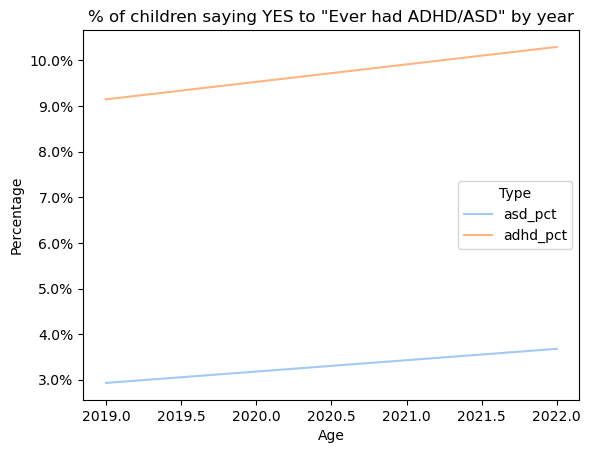

In [13]:
def percentage_formatter(x, pos):
    return f'{(x * 100):.1f}%'

melted_df = pd.melt(dfcall_yearly, id_vars=['year'], value_vars=['asd_pct', 'adhd_pct'], var_name='Type', value_name='Value')
ax = sns.lineplot(x='year', y='Value', hue='Type', data=melted_df, palette='pastel')


# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('% of children saying YES to "Ever had ADHD/ASD" by year')
plt.xlabel('Age')
plt.ylabel('Percentage')

plt.show()

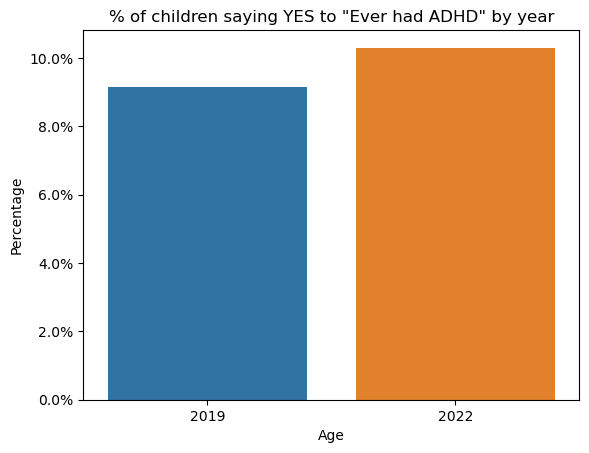

In [16]:
def percentage_formatter(x, pos):
    return f'{(x * 100):.1f}%'

dfcall_yearly = pd.DataFrame(dfcall.groupby('SRVY_YR')).reset_index()

# Children  ever diagnosed as adhd per year. 1 = yes, 2 = no
dfcall_adhd = pd.DataFrame(dfcall.loc[dfcall['ADHDEV_C']==1.0,['SRVY_YR','ADHDEV_C']].value_counts().sort_index().reset_index())
dfcall_adhd.rename({'count':'adhd_count'},axis=1,inplace=True)
dfcall_adhd['all_count'] = pd.DataFrame(dfcall.groupby('SRVY_YR')['ADHDEV_C'].count().reset_index())['ADHDEV_C']
dfcall_adhd['adhd_pct'] = dfcall_adhd['adhd_count'] / dfcall_adhd['all_count']


ax = sns.barplot(dfcall_adhd,x='SRVY_YR',y='adhd_pct')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('% of children saying YES to "Ever had ADHD" by year')
plt.xlabel('Age')
plt.ylabel('Percentage')

plt.show()

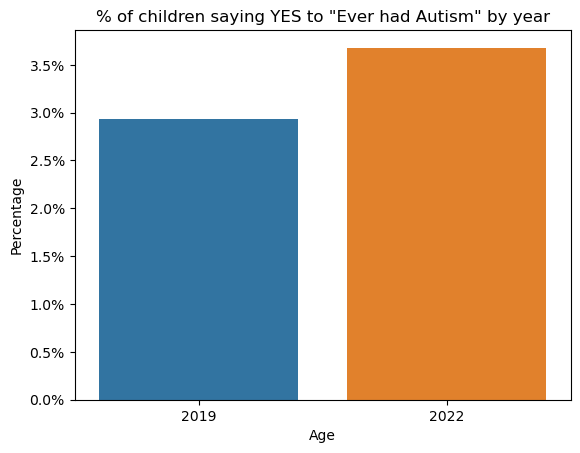

In [17]:
# Children  ever diagnosed as adhd per year. 1 = yes, 2 = no
dfcall_asd = pd.DataFrame(dfcall.loc[dfcall['ASDEV_C']==1.0,['SRVY_YR','ASDEV_C']].value_counts().sort_index().reset_index())
dfcall_asd.rename({'count':'asd_count'},axis=1,inplace=True)
dfcall_asd['all_count'] = pd.DataFrame(dfcall.groupby('SRVY_YR')['ASDEV_C'].count().reset_index())['ASDEV_C']
dfcall_asd['asd_pct'] = dfcall_asd['asd_count'] / dfcall_asd['all_count']

def percentage_formatter(x, pos):
    return f'{(x * 100):.1f}%'

ax = sns.barplot(dfcall_asd,x='SRVY_YR',y='asd_pct')

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('% of children saying YES to "Ever had Autism" by year')
plt.xlabel('Age')
plt.ylabel('Percentage')

plt.show()

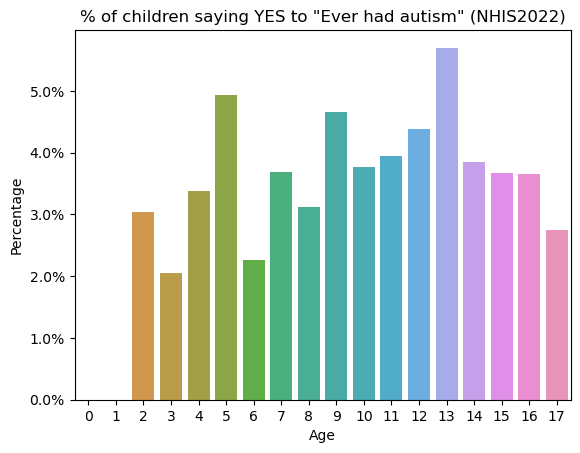

In [18]:
# Autistic percentage by age

dfc22_asd_age = pd.DataFrame(dfc22.groupby('AGEP_C')['ASDEV_C'].apply(lambda x: (x==1.0).sum())).reset_index()
dfc22_asd_age.rename({'ASDEV_C' : 'asd_count'},axis=1,inplace=True)
dfc22_asd_age['all_count'] = dfc22.groupby('AGEP_C')['AGEP_C'].count()
dfc22_asd_age['asd_pct'] = dfc22_asd_age['asd_count'] / dfc22_asd_age['all_count']
ax = sns.barplot(dfc22_asd_age,x='AGEP_C',y='asd_pct')

def percentage_formatter(x, pos):
    return f'{(x * 100):.1f}%'

# Apply the formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.title('% of children saying YES to "Ever had autism" (NHIS2022)')
plt.xlabel('Age')
plt.ylabel('Percentage')

plt.show()

Rough next steps
* Check max/min value for all fields to see which ones we can remove 7-9
* Additionally, check which fields we can map 1 (yes) and 2(no) to 0 (no) and 1 (yes)
* Put the ones to convert onto spreadsheet
* Make a function to do the 7-9 removing and 1-2 mapping
* Do the mapping


## Data transformation

### Modifying values based on type of question

In [35]:
# Identifying columns to transform based on the max value for the column
column_maxes = (dfcall.describe().transpose().reset_index()).loc[:,['index','max']].sort_values(by='max',ascending=False)


# If max value = 88, that column is a numeric field (e.g. SQD impact score), but 88 being "Not ascertained". Therefore, changing it to null
max_eighty_eights = column_maxes.loc[column_maxes['max'] ==88,'index'].tolist()
for column in max_eighty_eights:
    dfcall.loc[dfcall[column] == 88,column] = None

# If max value is 8 or 9, then it is an ordinal value (1~5 OR 1~3), with 7 = refused, 8 = not ascertained, 9 = Don't know. We are going to change these to null
max_eight_or_nines = column_maxes.loc[column_maxes['max'].isin([8.0,9.0]),'index'].tolist()
for column in max_eight_or_nines:
    dfcall.loc[dfcall[column].isin([7.0,8.0,9.0]),column] = None

# Changing binary columns to 0s and 1s (currently 1s and 2s)
binaries = column_maxes.loc[column_maxes['max'].isin([2.0]),'index'].tolist()
for column in binaries:
    dfcall.loc[dfcall[column].isin([2.0]),column] = 0.0

    

In [36]:
(dfcall.describe().transpose().reset_index()).loc[:,['index','max']].sort_values(by='max',ascending=False)


,index,max
1,SRVY_YR,2022.0
95,SDQTOT_C,38.0
0,RECTYPE,20.0
7,AGEP_C,17.0
98,RATCAT_C,14.0
3,INTV_MON,12.0
97,POVRATTC_C,11.0
96,SDQIMPTOT_C,10.0
94,SDQPROS_C,10.0
93,SDQPEER_C,10.0


In [46]:
dfcall_temp = dfcall.drop(columns=['HHX'])
dfcall_temp = dfcall_temp.loc[dfcall_temp['AGEP_C'] >= 3,:]
dfcall_corr = dfcall_temp.corrwith(dfcall_temp['ADHDEV_C']).sort_values(ascending=False).reset_index()

In [47]:
dfcall_corr['Description'] = pd.merge(dfcall_corr, cookbook_child, left_on='index', right_on='Variable Name')['Description']
dfcall_corr

,index,0,Description
0,ADHDEV_C,1.000000,Ever had ADD/ADHD
1,MHRX_C,0.598363,Took medication for\remotions/concentration/be...
2,SDQHYPE_C,0.477913,Hyperactivity Subscale Score
3,SDQIMP1_C,0.451406,"Difficulties with emotions, behaviors"
4,SDQ15_C,0.435198,Easily distracted
5,SDQTOT_C,0.431635,SDQ total score
6,SDQ2_C,0.367709,"Restless, cannot stay still"
7,SCHSPEDEV_C,0.366815,Ever received special education
8,SDQ10_C,0.352003,Constantly fidgeting/squirming
9,SDQIMP6_C,0.349467,Difficulties intefere with classroom learning


In [39]:
dfcall.groupby('AGEP_C')[['ASDEV_C','UNDRSTYOU_C']].value_counts()

AGEP_C  ASDEV_C  UNDRSTYOU_C
2       0.0      1.0            828
                 2.0             18
        1.0      1.0              8
                 2.0              4
                 3.0              2
3       0.0      1.0            826
                 2.0             17
        1.0      1.0             10
                 2.0              8
                 3.0              2
        0.0      4.0              1
4       0.0      1.0            771
                 2.0             20
        1.0      1.0             11
                 2.0              6
                 3.0              6
Name: count, dtype: int64

In [51]:
scaler = MinMaxScaler()
dfc_asd = dfcall[dfcall['ASDEV_C']==1.0].drop(columns=['HHX'])
dfc_asd_normalized = pd.DataFrame(scaler.fit_transform(dfc_asd), columns=dfc_asd.columns)
dfc_asd_normalized = dfc_asd_normalized.sum().sort_values(ascending=False) / dfc_asd_normalized.shape[0]
dfc_non_asd = dfcall[dfcall['ASDEV_C']==0.0].drop(columns=['HHX'])
dfc_non_asd_normalized = pd.DataFrame(scaler.fit_transform(dfc_non_asd), columns=dfc_non_asd.columns)
dfc_non_asd_normalized = dfc_non_asd_normalized.sum().sort_values(ascending=False) /dfc_non_asd_normalized.shape[0]
dfc_asd_pct = pd.concat([dfc_asd_normalized,dfc_non_asd_normalized],axis=1).reset_index()
dfc_asd_pct.rename({0:'asd_pct',1:'non_asd_pct'},axis=1,inplace=True)
dfc_asd_pct['diff'] = (dfc_asd_pct['asd_pct'] - dfc_asd_pct['non_asd_pct'])
dfc_asd_pct['Description'] = pd.merge(dfc_asd_pct, cookbook_child, left_on='index', right_on='Variable Name')['Description']

dfc_asd_pct.sort_values(by='diff',ascending=False)


C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,index,asd_pct,non_asd_pct,diff,Description
0,ASDNW_C,0.923554,0.000000,0.923554,Currently has autism
1,SCHSPEDEV_C,0.828512,0.126224,0.702289,Ever received special education
6,SCHSPED_C,0.706612,0.078112,0.628500,Currently receives special education
14,SCHSPEDEM_C,0.617769,0.041608,0.576160,Currently receives services for mental health
3,SDQIMP2_C,0.776860,0.217040,0.559820,Length of time with difficulties
28,LDEV_C,0.477273,0.056993,0.420280,Ever had learning disability
13,SDQ15_C,0.622934,0.213322,0.409612,Easily distracted
30,LDNW_C,0.450413,0.047762,0.402651,Currently has learning disability
32,ADHDEV_C,0.444215,0.084755,0.359460,Ever had ADD/ADHD
19,SDQHYPE_C,0.551033,0.192441,0.358592,Hyperactivity Subscale Score


(14300, 99)

In [52]:
scaler = MinMaxScaler()
dfc_asd = dfcall[dfcall['ADHDEV_C']==1.0].drop(columns=['HHX'])
dfc_asd_normalized = pd.DataFrame(scaler.fit_transform(dfc_asd), columns=dfc_asd.columns)
dfc_asd_normalized = dfc_asd_normalized.sum().sort_values(ascending=False) / dfc_asd_normalized.shape[0]
dfc_non_asd = dfcall[dfcall['ADHDEV_C']==0.0].drop(columns=['HHX'])
dfc_non_asd_normalized = pd.DataFrame(scaler.fit_transform(dfc_non_asd), columns=dfc_non_asd.columns)
dfc_non_asd_normalized = dfc_non_asd_normalized.sum().sort_values(ascending=False) /dfc_non_asd_normalized.shape[0]
dfc_asd_pct = pd.concat([dfc_asd_normalized,dfc_non_asd_normalized],axis=1).reset_index()
dfc_asd_pct.rename({0:'asd_pct',1:'non_asd_pct'},axis=1,inplace=True)
dfc_asd_pct['diff'] = (dfc_asd_pct['asd_pct'] - dfc_asd_pct['non_asd_pct'])
dfc_asd_pct['Description'] = pd.merge(dfc_asd_pct, cookbook_child, left_on='index', right_on='Variable Name')['Description']

dfc_asd_pct.sort_values(by='diff',ascending=False)


C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,index,asd_pct,non_asd_pct,diff,Description
1,ADHDNW_C,0.891760,0.000000,0.891760,Currently has ADD/ADHD
9,SDQIMP2_C,0.770251,0.177874,0.592377,Length of time with difficulties
16,MHRX_C,0.580307,0.027813,0.552494,Took medication for\remotions/concentration/be...
13,SDQ15_C,0.687500,0.177300,0.510200,Easily distracted
19,SCHSPEDEV_C,0.544693,0.106830,0.437863,Ever received special education
17,SDQHYPE_C,0.565154,0.165357,0.399796,Hyperactivity Subscale Score
21,SDQ2_C,0.526187,0.130632,0.395555,"Restless, cannot stay still"
29,SDQIMP6_C,0.424115,0.055526,0.368589,Difficulties intefere with classroom learning
24,SDQ10_C,0.479050,0.111515,0.367535,Constantly fidgeting/squirming
27,MHTHRPY_C,0.439944,0.072869,0.367075,Received counseling/therapy from mental health...
